In [1]:
import os

from datasets import load_from_disk

from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

In [2]:
hf_dataset = load_from_disk("./../data/")

In [3]:
# data_transforms = transforms.Compose([
#     transforms.Resize(224), 
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])

In [4]:
category_names = {
    0: "galaxy",
    1: "Galaxy",
    2: "Star",
    3: "defect",
    4: "galaxy",
    5: "stars-galaxies"
}

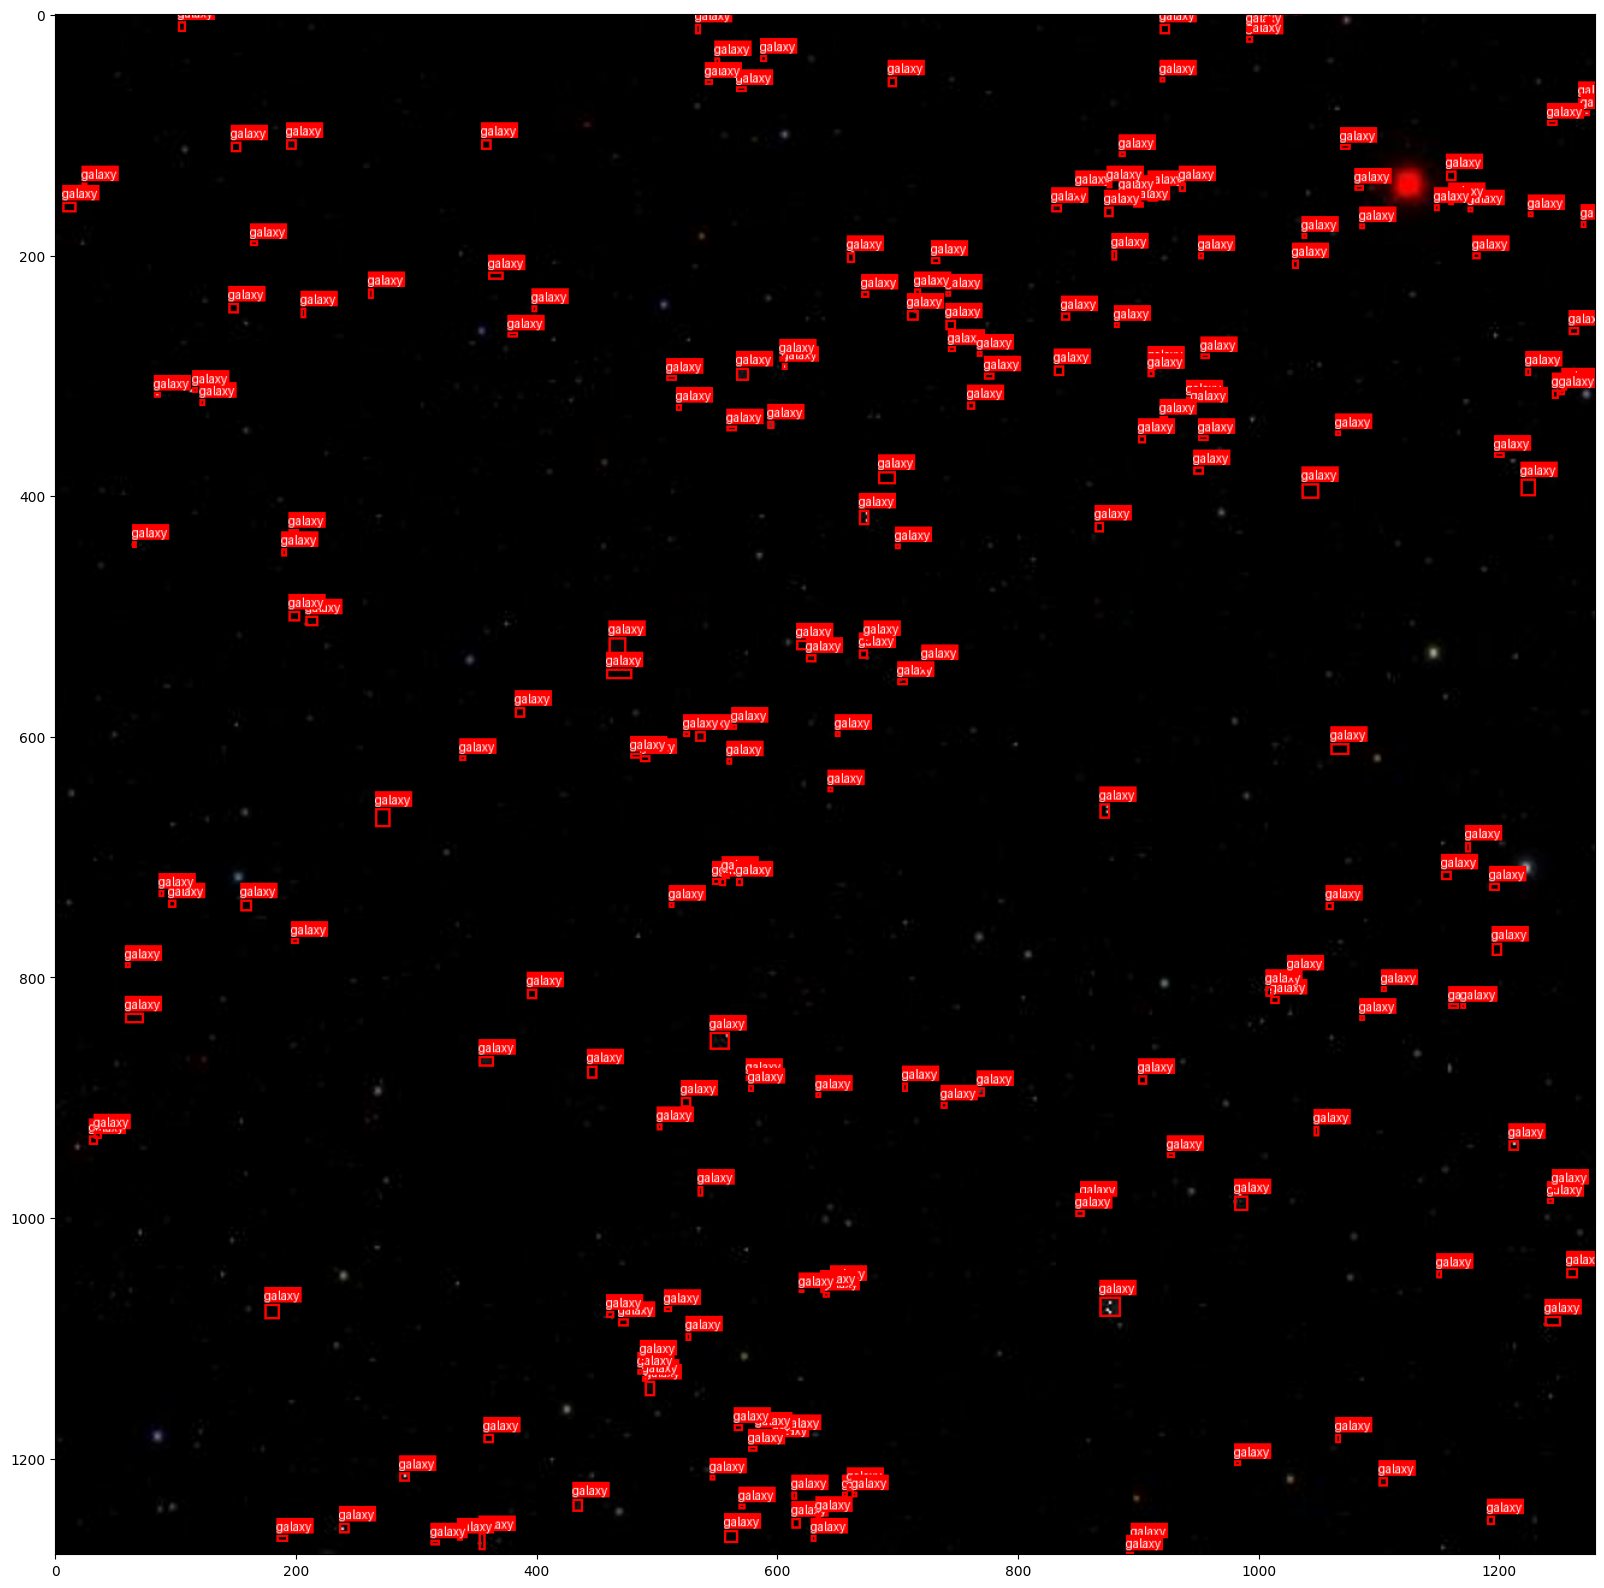

In [5]:
def visualize_image_and_annotations(example):
    image = Image.open(example["image_path"])
    image = image.resize((image.width * 2, image.height * 2))
    draw = ImageDraw.Draw(image)
    font = ImageFont.load_default()

    for annotation in example['annotations']:
        bbox = annotation['bbox']
        bbox = [coord * 2 for coord in bbox]
        draw.rectangle([(bbox[0], bbox[1]), (bbox[0] + bbox[2], bbox[1] + bbox[3])], outline="red", width=2)
        category_name = category_names.get(annotation['category_id'], "Desconhecido")
        text_width, text_height = font.getbbox(category_name)[2:4]
        draw.rectangle([(bbox[0], bbox[1] - text_height - 2), (bbox[0] + text_width, bbox[1] - 2)], fill="red")
        draw.text((bbox[0], bbox[1] - text_height - 1), category_name, fill="white", font=font)
    plt.figure(figsize=(20, 20))
    plt.imshow(image)
    plt.show()
    
example = hf_dataset[5]
visualize_image_and_annotations(example)

In [6]:
data_transforms = transforms.Compose([
    transforms.ToTensor(),
])

In [7]:
class GalaxyDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, transforms):
        self.dataset = dataset
        self.transforms = transforms

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image_path = self.dataset[idx]["image_path"]
        image = Image.open(image_path).convert("RGB")
        if self.transforms:
            image = self.transforms(image)

        annotations = self.dataset[idx]["annotations"]
        target = {}
        boxes = []
        labels = []
        for annotation in annotations:
            bbox = annotation["bbox"]
            boxes.append([bbox[0], bbox[1], bbox[0] + bbox[2], bbox[1] + bbox[3]])
            labels.append(annotation["category_id"])
        target["boxes"] = torch.tensor(boxes, dtype=torch.float32)
        target["labels"] = torch.tensor(labels, dtype=torch.int64)

        return image, target

In [8]:
train_dataset = GalaxyDataset(hf_dataset, data_transforms)
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=lambda batch: tuple(zip(*batch)))

In [9]:
# sample_indices = list(range(500))  # Seleciona os primeiros 10 índices
# train_dataset = GalaxyDataset(hf_dataset, data_transforms)
# sampled_dataset = Subset(train_dataset, sample_indices)

# # DataLoader para carregar o subconjunto de dados em batches
# train_dataloader = DataLoader(sampled_dataset, batch_size=2, shuffle=True, collate_fn=lambda batch: tuple(zip(*batch)))

In [10]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

num_classes = len(category_names) + 1
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
# device = torch.device("cpu")
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9)
loss_fn = torch.nn.CrossEntropyLoss()

num_epochs = 1
for epoch in range(num_epochs):
    model.train()
    for images, targets in tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        optimizer.zero_grad()
        outputs = model(images, targets)

        # Calcule a perda total, que é a soma de todas as perdas individuais
        loss = outputs["loss_classifier"] + outputs["loss_box_reg"] + outputs["loss_objectness"] + outputs["loss_rpn_box_reg"]

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)
        optimizer.step()

        #print(f"Epoch {epoch+1}, Loss: {loss.item()}")

/home/rafael/.pyenv/versions/galaxy-detection/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/rafael/.pyenv/versions/galaxy-detection/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/1:   0%|          | 0/303 [00:00<?, ?it/s]

In [36]:
# import os
# from datasets import load_from_disk
# from PIL import Image, ImageDraw, ImageFont
# import matplotlib.pyplot as plt
# import torch
# import torchvision
# import torchvision.transforms as transforms
# from torch.utils.data import DataLoader, Subset
# from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
# from tqdm import tqdm  # Importando tqdm para mostrar o progresso

# # Carrega o dataset do Hugging Face a partir do disco
# hf_dataset = load_from_disk("./../data/")

# # Dicionário para mapear IDs de categorias para nomes
# category_names = {
#     0: "galaxy",
#     1: "Galaxy",
#     2: "Star",
#     3: "defect",
#     4: "galaxy",
#     5: "stars-galaxies"
# }

# # Transforma as imagens em tensores para serem usadas na rede neural
# data_transforms = transforms.Compose([
#     transforms.ToTensor(),
# ])

# # Classe personalizada para carregar o dataset de galáxias
# class GalaxyDataset(torch.utils.data.Dataset):
#     def __init__(self, dataset, transforms):
#         self.dataset = dataset
#         self.transforms = transforms

#     def __len__(self):
#         return len(self.dataset)

#     def __getitem__(self, idx):
#         image_path = self.dataset[idx]["image_path"]
#         image = Image.open(image_path).convert("RGB")
#         if self.transforms:
#             image = self.transforms(image)

#         annotations = self.dataset[idx]["annotations"]
#         target = {}
#         boxes = []
#         labels = []
#         for annotation in annotations:
#             bbox = annotation["bbox"]
#             boxes.append([bbox[0], bbox[1], bbox[0] + bbox[2], bbox[1] + bbox[3]])
#             labels.append(annotation["category_id"])
#         target["boxes"] = torch.tensor(boxes, dtype=torch.float32)
#         target["labels"] = torch.tensor(labels, dtype=torch.int64)

#         return image, target

# # Cria um subconjunto com apenas 10 amostras
# sample_indices = list(range(20))  # Seleciona os primeiros 10 índices
# train_dataset = GalaxyDataset(hf_dataset, data_transforms)
# sampled_dataset = Subset(train_dataset, sample_indices)

# # DataLoader para carregar o subconjunto de dados em batches
# train_dataloader = DataLoader(sampled_dataset, batch_size=2, shuffle=True, collate_fn=lambda batch: tuple(zip(*batch)))

# # Carrega uma versão menor da Faster R-CNN, mais simples e leve
# model = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_320_fpn(pretrained=True)

# # Ajusta o classificador para o número de classes no dataset
# num_classes = len(category_names) + 1
# in_features = model.roi_heads.box_predictor.cls_score.in_features
# model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# # Define o dispositivo para treinamento (CPU ou GPU)
# device = torch.device("cpu")
# model.to(device)

# # Configura o otimizador
# params = [p for p in model.parameters() if p.requires_grad]
# optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9)

# # Define o número de épocas de treinamento
# num_epochs = 1
# for epoch in range(num_epochs):
#     model.train()
#     # Use tqdm para monitorar o progresso do treinamento
#     for images, targets in tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs}"):
#         images = list(image.to(device) for image in images)
#         targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

#         optimizer.zero_grad()
#         outputs = model(images, targets)

#         # Calcule a perda total, que é a soma de todas as perdas individuais
#         loss = sum(loss for loss in outputs.values())

#         # Backpropagation
#         loss.backward()

#         # Clip de gradiente para evitar gradientes explosivos
#         torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)

#         optimizer.step()

#         # Exibe a perda atual
#         print(f"Loss: {loss.item()}")

# # Exibe o tamanho dos objetos de treino (imagens e targets)
# print(f"Training data size: {len(sampled_dataset)}")
# print(f"Number of batches: {len(train_dataloader)}")


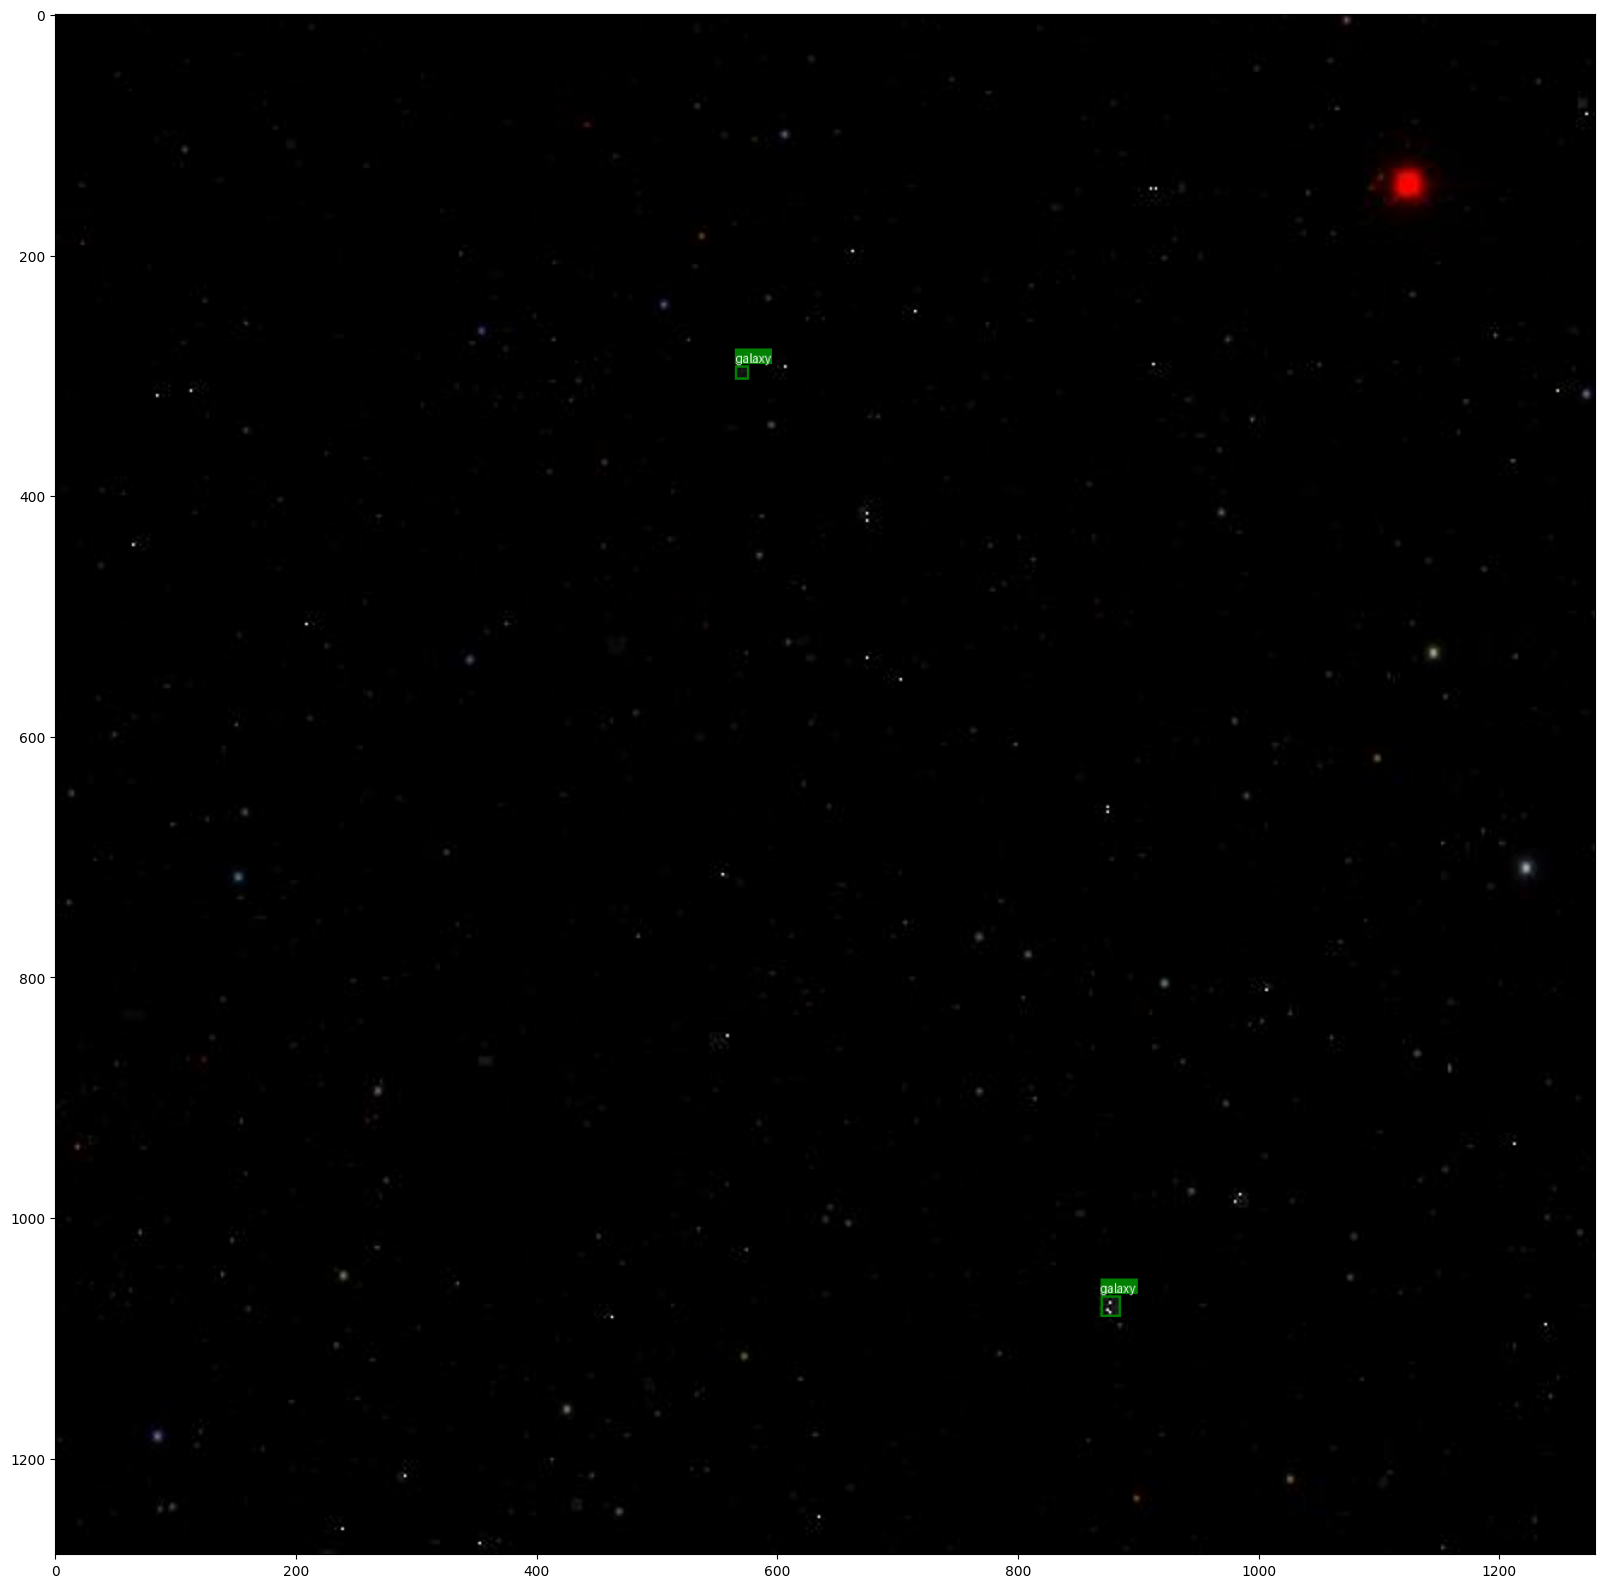

In [55]:
def predict_and_visualize(model, image_path, threshold=0.2):
    """
    Faz a predição em uma imagem e exibe a imagem com as predições.

    Args:
    - model: O modelo treinado para fazer as predições.
    - image_path: Caminho para a imagem a ser testada.
    - threshold: Limite de confiança para exibir as predições.
    """
    # Carregar e transformar a imagem
    image = Image.open(image_path).convert("RGB")
    transformed_image = data_transforms(image)
    
    # Colocar a imagem em um batch (de tamanho 1) e enviar para o dispositivo correto
    model.eval()
    with torch.no_grad():
        prediction = model([transformed_image.to(device)])
    
    # Convertendo a imagem para o formato original para exibir
    image = image.resize((image.width * 2, image.height * 2))
    draw = ImageDraw.Draw(image)
    font = ImageFont.load_default()

    # Desenhar as predições na imagem
    for idx, (box, score, label) in enumerate(zip(prediction[0]['boxes'], prediction[0]['scores'], prediction[0]['labels'])):
        #print((box, score, label))
        if score >= threshold:
            # Converter coordenadas para o formato original da imagem
            box = box.cpu().numpy() * 2
            draw.rectangle([(box[0], box[1]), (box[2], box[3])], outline="green", width=2)
            category_name = category_names.get(label.item(), "Desconhecido")
            text_width, text_height = font.getbbox(category_name)[2:4]
            draw.rectangle([(box[0], box[1] - text_height - 2), (box[0] + text_width, box[1] - 2)], fill="green")
            draw.text((box[0], box[1] - text_height - 1), category_name, fill="white", font=font)

    # Exibir a imagem com predições
    plt.figure(figsize=(20, 20))
    plt.imshow(image)
    plt.show()

# Exemplo de uso
image_path = hf_dataset[5]["image_path"]
predict_and_visualize(model, image_path, threshold=0.7)